En esta v2 simplemente he añadido una capa lineal más entre la capa lstm y la capa lineal de salida. Quedaría probar si un dropout me cambia en algo

In [40]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [41]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs


import train

In [42]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

# Datos ConvAI2

In [43]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [44]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [45]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False)

In [46]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False)

# Datos md_gender

In [47]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [48]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True)

# Creación dataloaders

In [49]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [50]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [51]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# ABOUT

In [52]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [53]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about'

In [54]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5102040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.4810606060606061 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.48370273794002605 

Using scikit learn accuracy por género en el conjunto as
MALE 0.0
FEMALE 1.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6942241805563405 	 Validation loss: 0.6923042697421575 	 
  1%|          | 574/57400 [00:02<03:42, 255.72it/s]
Epoch 2 	 Training loss: 0.6904909870350402 	 Validation loss: 0.6896047026424085 	 
  2%|▏         | 1148/57400 [00:04<03:41, 253.58it/s]
Epoch 3 	 Training loss: 0.6878442718592255 	 Validation loss: 0.6877294071650101 	 
  3%|▎         | 1722/57400 [00:07<03:48, 243.72it/s]
Epoch 4 	 Training loss: 0.6859445793080413 	 Validation loss: 0.6863815188407898 	 
  4%|▍         | 2296/57400 [00:09<03:37, 253.61it/s]
Epoch 5 	 Training loss: 0.6846219706203048 	 Validation loss: 0.6855843420756065 	 
  5%|▌         | 2870/57400 [00:12<03:38, 249.56it/s]
Epoch 6 	 Training loss: 0.6836317016480277 	 Validation loss: 0.6849998639801801 	 
  6%|▌         | 3444/57400 [00:14<03:33, 252.23it/s]
Epoch 7 	 Training loss: 0.6829468454218077 	 Validation loss: 0.684629453440844 	 
  7%|▋         | 4018/57400 [00:17<03:29, 254.82it/s]
Epoch 8 	 Training loss: 0.68

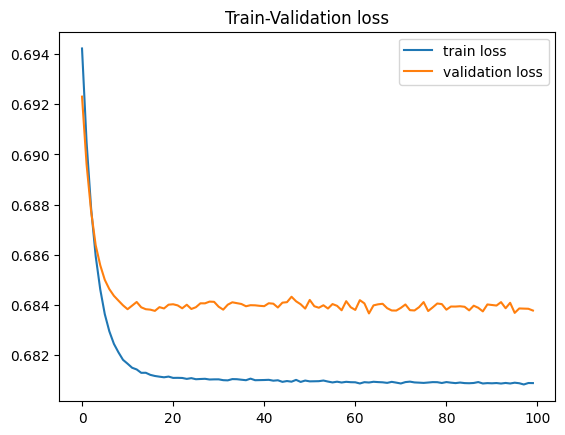

In [55]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [56]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [57]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [58]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693168832346122 	 Validation loss: 0.6932730735358545 	 
  1%|          | 574/57400 [00:03<04:31, 209.46it/s]
Epoch 2 	 Training loss: 0.6931496897017915 	 Validation loss: 0.693224731138197 	 
  2%|▏         | 1148/57400 [00:06<04:32, 206.28it/s]
Epoch 3 	 Training loss: 0.6931708830989611 	 Validation loss: 0.6930071064981363 	 
  3%|▎         | 1722/57400 [00:09<04:25, 209.72it/s]
Epoch 4 	 Training loss: 0.6931473334491876 	 Validation loss: 0.6931056612629002 	 
  4%|▍         | 2296/57400 [00:12<04:26, 206.83it/s]
Epoch 5 	 Training loss: 0.6931501209528189 	 Validation loss: 0.6931150222228746 	 
  5%|▌         | 2870/57400 [00:15<04:24, 206.11it/s]
Epoch 6 	 Training loss: 0.6931930509386163 	 Validation loss: 0.6929976960359994 	 
  6%|▌         | 3444/57400 [00:17<04:11, 214.24it/s]
Epoch 7 	 Training loss: 0.69318822057405 	 Validation loss: 0.6929701031264612 	 
  7%|▋         | 4018/57400 [00:20<04:18, 206.77it/s]
Epoch 8 	 Training loss: 0.69317

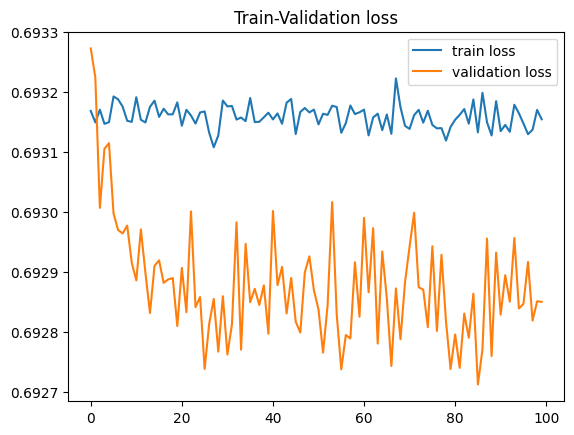

In [59]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [60]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.48086734693877553 

Using scikit learn accuracy por género en el conjunto about
MALE 0.6015625
FEMALE 0.365 

GLOBAL: 0.5202020202020202 

Using scikit learn accuracy por género en el conjunto to
MALE 0.6374695863746959
FEMALE 0.3937007874015748 

GLOBAL: 0.5176010430247718 

Using scikit learn accuracy por género en el conjunto as
MALE 0.6792929292929293
FEMALE 0.3450134770889488 



# AS

In [75]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.696450714242583 	 Validation loss: 0.6923872798176135 	 
  1%|          | 574/57400 [00:04<06:12, 152.44it/s]
Epoch 2 	 Training loss: 0.6955383671285383 	 Validation loss: 0.6929079011335211 	 
  2%|▏         | 1148/57400 [00:08<06:16, 149.21it/s]
Epoch 3 	 Training loss: 0.6946177158621546 	 Validation loss: 0.6914433523760004 	 
  3%|▎         | 1722/57400 [00:12<06:12, 149.44it/s]
Epoch 4 	 Training loss: 0.6943677974287226 	 Validation loss: 0.6916918168633671 	 
  4%|▍         | 2296/57400 [00:16<05:51, 156.94it/s]
Epoch 5 	 Training loss: 0.6942776170549493 	 Validation loss: 0.6917318287542311 	 
  5%|▌         | 2870/57400 [00:20<06:04, 149.49it/s]
Epoch 6 	 Training loss: 0.6938418606847836 	 Validation loss: 0.6924213413464821 	 
  6%|▌         | 3444/57400 [00:24<05:37, 159.66it/s]
Epoch 7 	 Training loss: 0.693755937785637 	 Validation loss: 0.6919070249896938 	 
  7%|▋         | 4018/57400 [00:28<05:43, 155.58it/s]
Epoch 8 	 Training loss: 0.693

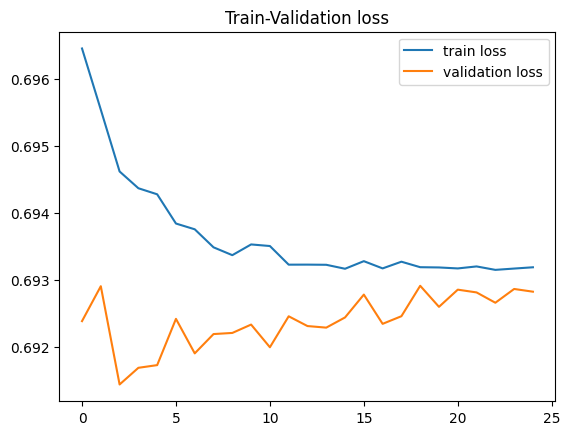

In [62]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [76]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5102040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.4810606060606061 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.48370273794002605 

Using scikit learn accuracy por género en el conjunto as
MALE 0.0
FEMALE 1.0 



# AdamW

## ABOUT

In [73]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_adam'

In [65]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6796584183330735 	 Validation loss: 0.6807371630507001 	 
  1%|          | 574/57400 [00:04<06:33, 144.44it/s]
Epoch 2 	 Training loss: 0.6681322489673668 	 Validation loss: 0.6689657144627329 	 
  2%|▏         | 1148/57400 [00:08<06:22, 147.13it/s]
Epoch 3 	 Training loss: 0.657339423998723 	 Validation loss: 0.6638617707511126 	 
  3%|▎         | 1722/57400 [00:12<06:06, 151.77it/s]
Epoch 4 	 Training loss: 0.6486071247464689 	 Validation loss: 0.6557466670618219 	 
  4%|▍         | 2296/57400 [00:16<05:56, 154.48it/s]
Epoch 5 	 Training loss: 0.6400465529139449 	 Validation loss: 0.6490664360886913 	 
  5%|▌         | 2870/57400 [00:20<06:10, 147.08it/s]
Epoch 6 	 Training loss: 0.631690575063021 	 Validation loss: 0.6418969762527337 	 
  6%|▌         | 3444/57400 [00:24<06:08, 146.32it/s]
Epoch 7 	 Training loss: 0.6237730369335268 	 Validation loss: 0.6371978945651297 	 
  7%|▋         | 4018/57400 [00:28<05:53, 150.85it/s]
Epoch 8 	 Training loss: 0.616

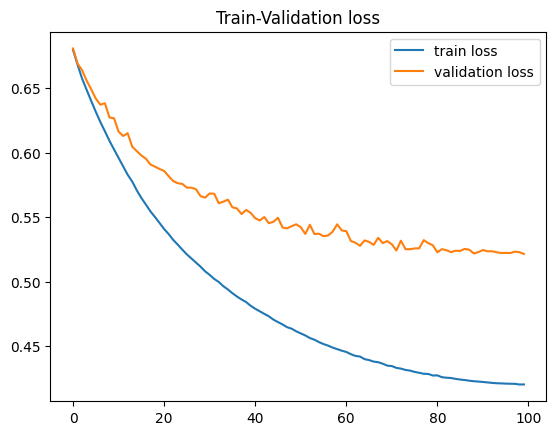

In [66]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [74]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5727040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.17447916666666666
FEMALE 0.955 

GLOBAL: 0.49242424242424243 

Using scikit learn accuracy por género en el conjunto to
MALE 0.09975669099756691
FEMALE 0.916010498687664 

GLOBAL: 0.5189048239895697 

Using scikit learn accuracy por género en el conjunto as
MALE 0.1111111111111111
FEMALE 0.954177897574124 



## TO

In [67]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932959388357421 	 Validation loss: 0.6932763376478421 	 
  1%|          | 574/57400 [00:03<05:16, 179.45it/s]
Epoch 2 	 Training loss: 0.6932020985914025 	 Validation loss: 0.692412891630399 	 
  2%|▏         | 1148/57400 [00:06<05:13, 179.69it/s]
Epoch 3 	 Training loss: 0.693190066345062 	 Validation loss: 0.6924786981889757 	 
  3%|▎         | 1722/57400 [00:10<05:09, 179.91it/s]
Epoch 4 	 Training loss: 0.6931602069102097 	 Validation loss: 0.692419124861895 	 
  4%|▍         | 2296/57400 [00:13<05:09, 178.21it/s]
Epoch 5 	 Training loss: 0.6930597280168367 	 Validation loss: 0.6921627036595749 	 
  5%|▌         | 2870/57400 [00:17<05:04, 179.13it/s]
Epoch 6 	 Training loss: 0.6931502826330138 	 Validation loss: 0.6937464415016821 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:20<04:55, 182.69it/s]
Epoch 7 	 Training loss: 0.6930397181976132 	 Validation loss: 0.6941804562584829 	 

2 epoch without improvement
  7%|▋         | 4018/57400

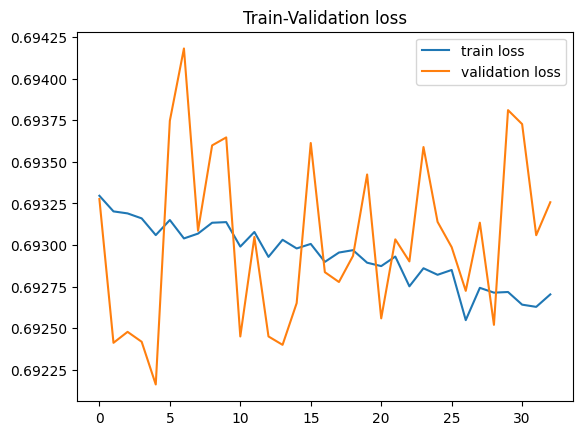

In [68]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [69]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.514030612244898 

Using scikit learn accuracy por género en el conjunto about
MALE 0.028645833333333332
FEMALE 0.98 

GLOBAL: 0.47095959595959597 

Using scikit learn accuracy por género en el conjunto to
MALE 0.012165450121654502
FEMALE 0.9658792650918635 

GLOBAL: 0.48891786179921776 

Using scikit learn accuracy por género en el conjunto as
MALE 0.03787878787878788
FEMALE 0.9703504043126685 



## AS

In [70]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932455846449224 	 Validation loss: 0.69354504649922 	 
  1%|          | 574/57400 [00:03<05:14, 180.92it/s]
Epoch 2 	 Training loss: 0.6931999141953964 	 Validation loss: 0.6928345702462277 	 
  2%|▏         | 1148/57400 [00:06<05:18, 176.69it/s]
Epoch 3 	 Training loss: 0.6931051105157008 	 Validation loss: 0.693623838788372 	 
  3%|▎         | 1722/57400 [00:10<05:09, 179.92it/s]
Epoch 4 	 Training loss: 0.6931360009862986 	 Validation loss: 0.6937538072214289 	 
  4%|▍         | 2296/57400 [00:13<05:07, 179.32it/s]
Epoch 5 	 Training loss: 0.6929667251450675 	 Validation loss: 0.692753241223804 	 
  5%|▌         | 2870/57400 [00:17<05:03, 179.88it/s]
Epoch 6 	 Training loss: 0.6929651309804219 	 Validation loss: 0.6928056124913491 	 
  6%|▌         | 3444/57400 [00:20<05:02, 178.57it/s]
Epoch 7 	 Training loss: 0.693002163117771 	 Validation loss: 0.6934678261562929 	 
  7%|▋         | 4018/57400 [00:24<04:54, 181.44it/s]
Epoch 8 	 Training loss: 0.692893

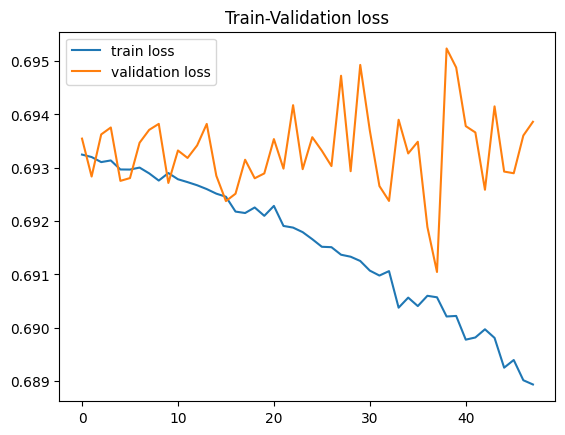

In [71]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [72]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5153061224489796 

Using scikit learn accuracy por género en el conjunto about
MALE 0.5182291666666666
FEMALE 0.5125 

GLOBAL: 0.5063131313131313 

Using scikit learn accuracy por género en el conjunto to
MALE 0.5182481751824818
FEMALE 0.49343832020997375 

GLOBAL: 0.5410691003911343 

Using scikit learn accuracy por género en el conjunto as
MALE 0.5681818181818182
FEMALE 0.5121293800539084 

